In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import cross_val_predict 

In [2]:
df = pd.read_csv('Datos_Ibague.csv', sep=';')
df.head()

,OBJECTID,OBJECTID_1,Codigo_Uni,fecha,municipio,comuna,zona,subzona,cod_censista,num_arbol,familia,nom_cientifico,nom_comun,procedencia,UICN,habito_creciemiento,emplazamiento,altura_fuste,altura_total,diametro_copa,diametro_normal,volumen_m3,inc,rd,dm,bbs,abs,estado_fisico,pi,ph,pa,pd,pe,pp,po,estado_sanitario,densidad_follaje,valor_estetico,cre,crh,cra,coa,ce,civ,crt,crg,cap,r_vol,r_cr,r_ce,fotografia,fase,GlobalID,X,Y,Barrio
0,98717,56585,67352 - F3,16/05/2017,Ibague,7,4,4,Cuadrilla_12,67352,Myrtaceae,Syzygium_malaccense,Pera_de_malaca,Exotica,LC,Arbol,Zona_blanda,3,"5,2",2,"18,3","0,523170648",0,0,0,0,0,Malo,20,0,0,80,0,0,0,Muerto,Ralo,Inaceptable,No,No,No,No,No,No,No,No,No,0,0,0,C:\Users\juan-arias.CORTOLI1\Documents\ArcGIS\...,F3,{DF618195-9BA3-42B8-B900-153874CA5FD7},"883744,684","984472,5618",Otro
1,99083,61808,65768 - F3,16/05/2017,Ibague,7,4,4,Cuadrilla_10,65768,Fabaceae,Pithecellobium_dulce,Payande,Nativa,LC,Arbol,Zona_blanda,"0,5","4,9","2,5","17,7","0,476824194",0,0,20,40,20,Regular,0,0,0,20,0,0,0,Sano,Denso,Deseable,No,No,No,Si,No,No,No,No,No,0,0,0,C:\Users\juan-arias.CORTOLI1\Documents\ArcGIS\...,F3,{F03C72BE-7978-4F7C-B2D3-A6525632AE19},"883742,6131","984515,2839",Otro
2,98669,66706,65769 - F3,16/05/2017,Ibague,7,4,4,Cuadrilla_10,65769,Combretaceae,Terminalia_catappa,Almendro,Exotica,NE,Arbol,Zona_blanda,"3,5","5,5",5,27,"0,8164233",0,20,0,0,0,Bueno,0,0,0,20,0,0,0,Sano,Denso,Deseable,No,No,No,Si,No,Si,No,No,No,20,20,0,C:\Users\juan-arias.CORTOLI1\Documents\ArcGIS\...,F3,{0ADD2CC1-1E82-4EC2-B98D-7DD8016B71D3},"883741,3773","984466,8292",Otro
3,99327,59629,65767 - F3,16/05/2017,Ibague,7,4,4,Cuadrilla_10,65767,Fabaceae,Pithecellobium_dulce,Payande,Nativa,LC,Arbol,Zona_blanda,"0,6","3,8",3,"11,6","0,242343024",20,0,20,0,20,Regular,20,0,0,0,0,0,0,Sano,Denso,Deseable,No,No,No,Si,No,No,No,No,No,0,0,0,C:\Users\juan-arias.CORTOLI1\Documents\ArcGIS\...,F3,{03AAD258-1A06-4A17-8EB0-A7E5AA323338},"883741,158","984540,5588",Otro
4,98884,64850,66071 - F3,16/05/2017,Ibague,7,4,4,Cuadrilla_11,66071,Myrtaceae,Psidium_guajava,Guayabo,Nativa,NE,Arbol,Zona_blanda,"3,6","7,5",5,21,"0,8659035",20,0,0,0,0,Bueno,0,0,0,0,0,0,0,Sano,Denso,Deseable,No,No,No,Si,No,No,No,No,No,0,0,0,C:\Users\juan-arias.CORTOLI1\Documents\ArcGIS\...,F3,{A942F3CE-2719-416E-9F46-F3A03E97BD97},"883741,0111","984493,2908",Otro


In [3]:
df['fecha'] = pd.to_datetime(df.fecha)
def sort_unique(column_name):
    return df[column_name].sort_values().unique()
sci_names = list(sort_unique('nom_cientifico'))
def splitting_sci_names(name):
    if '?�' in name:
        return str(name).split('?�')
    return str(name).split('_')
split_names = list(map(splitting_sci_names, sci_names))

def grouping_trees_by_gender(split_names):
    trees_by_gender = {}
    for tree in split_names:
        gender = tree[0]
        specie = tree[1]
        if not gender in trees_by_gender:
            trees_by_gender[gender] = []
        trees_by_gender[gender].append(specie)
    return trees_by_gender

grouping_trees_by_gender(split_names)
def fixing_sci_names(name):
    if '?�' in name:
        return str(name).replace('?�', '_')
    return name

df['nom_cientifico'] = df.nom_cientifico.apply(fixing_sci_names)
df['familia'] = df.familia.str.strip()

dicc_UICN = {
    'CR':'En_peligro_critico',
    'EN':'En_peligro_vulnerable',
    'EW':'Extinto_en_estado_silvestre',
    'LC':'Preocupacion_menor',
    'NE':'No_evaluado',
    'NT':'Casi_amenazado',
    'VU':'Vulnerable'
}

df['UICN'] = df['UICN'].replace(to_replace=dicc_UICN)
df.rename(columns={'habito_creciemiento':'habito_crecimiento'}, inplace=True)
df.rename(columns={'estado_sanitario ':'estado_sanitario'}, inplace=True)
var = ['nom_cientifico','familia','nom_comun','procedencia','UICN','habito_crecimiento','emplazamiento','estado_fisico','densidad_follaje','valor_estetico','comuna','fase', 'Barrio']
df[var] = df[var].astype('category')
dicc_c = {
    'No':'0',
    'Si':'1'
}
var_c=['cre', 'crh', 'cra', 'coa', 'ce', 'civ', 'crt', 'crg', 'cap']
df[var_c] = df[var_c].replace(to_replace=dicc_c)
df[var_c] = df[var_c].astype('int64')

df.rename(columns={'altura_fuste ':'altura_fuste'}, inplace=True)
float_columns = ['altura_fuste', 'altura_total', 'diametro_copa', 'diametro_normal', 'volumen_m3']
for column in float_columns:
    df[column] = df[column].apply(lambda x: str(x).replace(',', '.'))
dypsis_median = df[(df.nom_cientifico == 'Dypsis_lutescens') & (df.comuna == 7) & (df.diametro_copa != '<NULL>')].diametro_copa.median()
df.at[857, 'diametro_copa'] = dypsis_median
cassia_mean = round((df[(df.nom_cientifico == 'Cassia_fistula') & (df.comuna == 7) & (df.diametro_copa != '<NULL>')].diametro_copa).astype('float').mean(), 1)
df.at[1720, 'diametro_copa'] = cassia_mean
syzygium_mean = round((df[(df.nom_cientifico == 'Syzygium_malaccense') & (df.comuna == 5) & (df.diametro_copa != '<NULL>')].diametro_copa).astype('float').mean(), 1)
df.at[50485, 'diametro_copa'] = syzygium_mean
for column in float_columns:
    df[column] = df[column].astype('float')

In [4]:
df=df[df['zona']!='--']
df=df[df['subzona']!='--']
df[df['fecha']!='1899-12-30']
df=df.drop(['fecha','cod_censista','municipio','nom_cientifico','nom_comun','OBJECTID','OBJECTID_1','Codigo_Uni','num_arbol', 'fotografia', 'GlobalID', 'X', 'Y', 'Barrio', 'zona', 'subzona', 'volumen_m3','diametro_copa','altura_total','inc','abs','dm','valor_estetico', 'fase', 'UICN', 'procedencia'],axis=1)

In [5]:
var_bool= ['rd', 'bbs', 'pi', 'ph', 'pa', 'pd', 'pe', 'pp', 'po', 'cre', 'crh', 'cra', 'coa','ce', 'civ', 'crt', 'crg', 'cap', 'r_vol', 'r_cr', 'r_ce']
df[var_bool]=np.where(df[var_bool]==0, 0, 1)
df

,comuna,familia,habito_crecimiento,emplazamiento,altura_fuste,diametro_normal,rd,bbs,estado_fisico,pi,ph,pa,pd,pe,pp,po,estado_sanitario,densidad_follaje,cre,crh,cra,coa,ce,civ,crt,crg,cap,r_vol,r_cr,r_ce
0,7,Myrtaceae,Arbol,Zona_blanda,3.0,18.3,0,0,Malo,1,0,0,1,0,0,0,Muerto,Ralo,0,0,0,0,0,0,0,0,0,0,0,0
1,7,Fabaceae,Arbol,Zona_blanda,0.5,17.7,0,1,Regular,0,0,0,1,0,0,0,Sano,Denso,0,0,0,1,0,0,0,0,0,0,0,0
2,7,Combretaceae,Arbol,Zona_blanda,3.5,27.0,1,0,Bueno,0,0,0,1,0,0,0,Sano,Denso,0,0,0,1,0,1,0,0,0,1,1,0
3,7,Fabaceae,Arbol,Zona_blanda,0.6,11.6,0,0,Regular,1,0,0,0,0,0,0,Sano,Denso,0,0,0,1,0,0,0,0,0,0,0,0
4,7,Myrtaceae,Arbol,Zona_blanda,3.6,21.0,0,0,Bueno,0,0,0,0,0,0,0,Sano,Denso,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101280,1,Myrtaceae,Arbol,Zona_blanda,1.6,5.1,0,0,Regular,1,1,1,1,0,0,0,Enfermo,Ralo,0,0,0,1,0,0,0,0,0,0,0,0
101281,1,Arecaceae,Palma,Zona_blanda,6.0,13.2,1,0,Bueno,0,0,0,0,1,0,1,Sano,Denso,0,0,0,0,1,0,1,0,0,0,1,1
101282,1,Myrtaceae,Arbol,Zona_blanda,1.4,19.0,0,0,Regular,1,0,0,1,0,0,0,Sano,Denso,0,0,0,1,0,0,0,0,0,1,1,0
101283,1,Malvaceae,Arbusto,Zona_blanda,2.0,5.0,0,1,Regular,1,0,0,0,0,0,0,Sano,Ralo,0,0,0,0,0,0,0,0,0,0,0,0


### Dataset division

In [6]:
df['estado_sanitario'].value_counts()

Sano       95736
Enfermo     3885
Muerto      1107
Critico      543
Name: estado_sanitario, dtype: int64

In [7]:
df_x=df.drop('estado_sanitario', axis=1)
df_y = df['estado_sanitario']
final_df_x = pd.get_dummies(df_x,columns=df_x.columns[df_x.dtypes=='category'])#, drop_first=True)
final_df_x

,altura_fuste,diametro_normal,rd,bbs,pi,ph,pa,pd,pe,pp,po,cre,crh,cra,coa,ce,civ,crt,crg,cap,r_vol,r_cr,r_ce,comuna_1,comuna_2,comuna_3,comuna_4,comuna_5,comuna_6,comuna_7,comuna_8,comuna_9,comuna_10,comuna_11,comuna_12,comuna_13,familia_Acanthaceae,familia_Adoxaceae,familia_Amaranthaceae,familia_Anacardiaceae,familia_Annonaceae,familia_Apocynaceae,familia_Araliaceae,familia_Araucariaceae,familia_Arecaceae,familia_Asparagaceae,familia_Asteraceae,familia_Basellaceae,familia_Bignoniaceae,familia_Bixaceae,familia_Boraginaceae,familia_Burseraceae,familia_Cactaceae,familia_Calophyllaceae,familia_Cannabaceae,familia_Capparidaceae,familia_Caricaceae,familia_Casuarinaceae,familia_Chrysobalanaceae,familia_Clusiaceae,familia_Combretaceae,familia_Compositae,familia_Cupressaceae,familia_Cycadaceae,familia_Erythroxylaceae,familia_Estrelitziaceae,familia_Euphorbiaceae,familia_Fabaceae,familia_Hernandiaceae,familia_Hipericaceae,familia_Juglandaceae,familia_Lacistemataceae,familia_Lamiaceae,familia_Lauraceae,familia_Lecythidaceae,familia_Leguminosae,familia_Lythraceae,familia_Magnoliaceae,familia_Malpighiaceae,familia_Malvaceae,familia_Melastomataceae,familia_Meliaceae,familia_Moraceae,familia_Moringaceae,familia_Muntingiaceae,familia_Myrtaceae,familia_Nyctaginaceae,familia_Ocnaceae,familia_Oleaceae,familia_Oxalidaceae,familia_Pandanaceae,familia_Passifloraceae,familia_Phyllanthaceae,familia_Pinaceae,familia_Piperaceae,familia_Plumbaginaceae,familia_Poaceae,familia_Podocarpaceae,familia_Poligonaceae,familia_Primulaceae,familia_Proteaceae,familia_Ramnaceae,familia_Rosaceae,familia_Rubiaceae,familia_Rutaceae,familia_Salicaceae,familia_Sapindaceae,familia_Sapotaceae,familia_Scrophulariaceae,familia_Simarubaceae,familia_Solanaceae,familia_Taxodiaceae,familia_Thymelaeaceae,familia_Urticaceae,familia_Verbenaceae,familia_Zygophyllaceae,habito_crecimiento_Arbol,habito_crecimiento_Arbusto,habito_crecimiento_Bambu,habito_crecimiento_Palma,emplazamiento_Alcorque,emplazamiento_Anden,emplazamiento_Antejardin,emplazamiento_Glorieta,emplazamiento_Parque,emplazamiento_Separador_vial,emplazamiento_Zona_blanda,estado_fisico_Bueno,estado_fisico_Malo,estado_fisico_Regular,densidad_follaje_Denso,densidad_follaje_Medio,densidad_follaje_Ralo
0,3.0,18.3,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1
1,0.5,17.7,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0
2,3.5,27.0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0
3,0.6,11.6,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0
4,3.6,21.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [8]:
#a=final_df_x
#a['estado_sanitario']=df_y
#a.to_csv('Base de datos final.csv', index=False)
#a

In [9]:
#df = pd.read_csv('Base de datos final.csv', sep=',')
#final_df_x=df.drop('estado_sanitario', axis=1)
#df_y = df['estado_sanitario']

In [10]:
#list(df.columns)

In [11]:
train_X, val_X, train_y, val_y = train_test_split(final_df_x, df_y, test_size=0.2,random_state=7) 
print(train_X.shape) 
print(val_X.shape)  

(81016, 133)
(20255, 133)


In [12]:
train_y.value_counts()

Sano       76624
Enfermo     3093
Muerto       870
Critico      429
Name: estado_sanitario, dtype: int64

In [13]:
sm=SMOTE()
train_X, train_y=sm.fit_resample(train_X, train_y)

In [14]:
train_y.value_counts()

Sano       76624
Enfermo    76624
Muerto     76624
Critico    76624
Name: estado_sanitario, dtype: int64

In [15]:
forest = RandomForestClassifier(random_state=7, n_estimators=100)

## Random Forest

In [16]:
forest.fit(train_X, train_y)
y_pred=forest.predict(val_X)
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the Random Forest model is',round(accuracy_score(val_y, y_pred)*100,2))
print(accuracy_score(val_y, y_pred))

--------------The Accuracy of the model----------------------------
The accuracy of the Random Forest model is 95.23
0.9522587015551716


In [17]:
kfold = KFold(n_splits=10, random_state=None)
result_rf=cross_val_score(forest,final_df_x,df_y,cv=10,scoring='accuracy')
print('The cross validated score for Random Forest model is:',round(result_rf.mean()*100,2))

The cross validated score for Random Forest model is: 95.06


In [18]:
print(classification_report(val_y, y_pred))

              precision    recall  f1-score   support

     Critico       0.39      0.11      0.18       114
     Enfermo       0.46      0.53      0.50       792
      Muerto       0.70      0.86      0.77       237
        Sano       0.98      0.98      0.98     19112

    accuracy                           0.95     20255
   macro avg       0.64      0.62      0.61     20255
weighted avg       0.95      0.95      0.95     20255



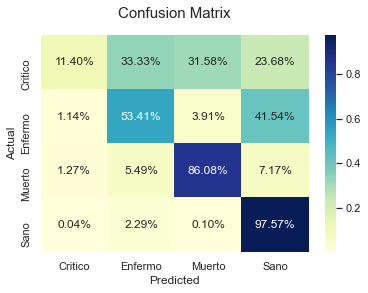

In [19]:
target_names=[ "Critico","Enfermo","Muerto","Sano"]
cm = confusion_matrix(val_y, y_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cmn, annot=True, fmt='.2%', cmap="YlGnBu",xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix', y=1.05, size=15);

In [23]:
import joblib
# save the model to disk
filename = 'finalized_model.pkl'
joblib.dump(forest, filename)
 
# some time later...
 
# load the model from disk
loaded_model = joblib.load(filename)
result = loaded_model.score(val_X, val_y)
print(result)

0.9522587015551716
